In [1]:
# ===============================
# IMPORT REQUIRED LIBRARIES
# ===============================

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os


C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# ===============================
# DATA PREPROCESSING
# ===============================

IMG_SIZE = 128
BATCH_SIZE = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2
)

train_data = datagen.flow_from_directory(
    "dataset/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    "dataset/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print("Class Labels:", train_data.class_indices)


Found 5303 images belonging to 4 classes.
Found 1324 images belonging to 4 classes.
Class Labels: {'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___healthy': 3}


In [3]:
# ===============================
# BUILD CUSTOM CNN MODEL
# ===============================

model = models.Sequential()

# Conv Block 1
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Conv Block 2
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Conv Block 3
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Flatten
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(train_data.num_classes, activation='softmax'))

model.summary()


C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,052 (12.61 MB)

 Trainable params: 3,305,604 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [4]:
# ===============================
# COMPILE MODEL
# ===============================

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [5]:
# ===============================
# TRAIN MODEL
# ===============================

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[early_stop]
)


Epoch 1/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 153s 450ms/step - accuracy: 0.4816 - loss: 1.5558 - val_accuracy: 0.4486 - val_loss: 6.9688
Epoch 2/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 105s 317ms/step - accuracy: 0.5410 - loss: 1.2146 - val_accuracy: 0.6360 - val_loss: 1.0466
Epoch 3/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 104s 312ms/step - accuracy: 0.5480 - loss: 1.1259 - val_accuracy: 0.6284 - val_loss: 0.9605
Epoch 4/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 105s 316ms/step - accuracy: 0.5848 - loss: 1.0566 - val_accuracy: 0.7032 - val_loss: 0.8308
Epoch 5/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 105s 315ms/step - accuracy: 0.6078 - loss: 1.0215 - val_accuracy: 0.7077 - val_loss: 0.8310
Epoch 6/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 103s 311ms/step - accuracy: 0.6064 - loss: 1.0310 - val_accuracy: 0.6715 - val_loss: 1.0325
Epoch 7/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 104s 313ms/step - accuracy: 0.6472 - loss: 0.9415 - val_accuracy: 0.7440 - val_loss: 0.7183
Epoch 8/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 104s 312ms/step - accuracy: 0.6807 -

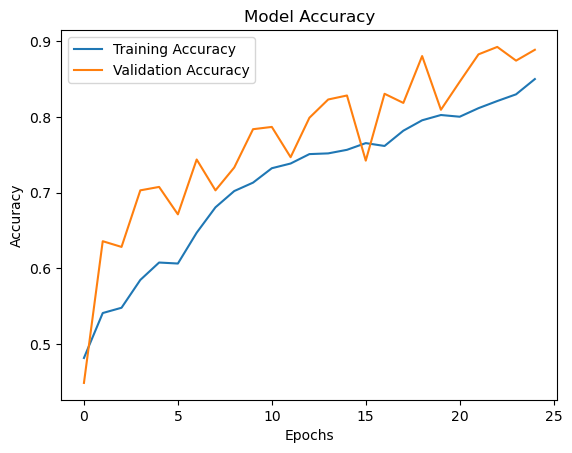

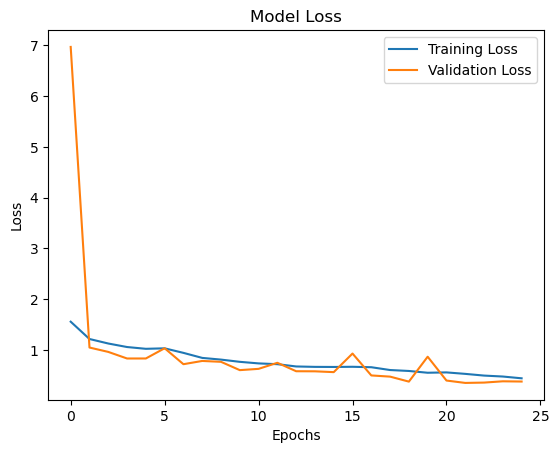

In [6]:
# ===============================
# PLOT ACCURACY & LOSS
# ===============================

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step
Classification Report:

                         precision    recall  f1-score   support

Tomato___Bacterial_spot       0.29      0.30      0.29       425
  Tomato___Early_blight       0.15      0.13      0.14       200
   Tomato___Late_blight       0.29      0.29      0.29       381
       Tomato___healthy       0.21      0.20      0.21       318

               accuracy                           0.25      1324
              macro avg       0.23      0.23      0.23      1324
           weighted avg       0.25      0.25      0.25      1324



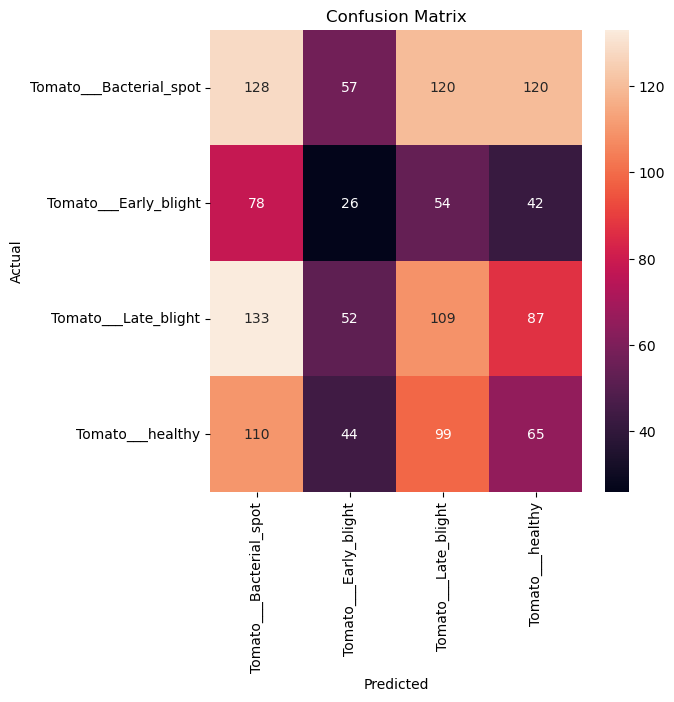

In [7]:
# ===============================
# CONFUSION MATRIX
# ===============================

val_data.reset()

Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_data.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred, 
      target_names=list(train_data.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=list(train_data.class_indices.keys()),
            yticklabels=list(train_data.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [8]:
# ===============================
# SAVE MODEL
# ===============================

model.save("tomato_disease_model.h5")
print("Model Saved Successfully!")


Model Saved Successfully!


In [9]:
# ===============================
# SINGLE IMAGE PREDICTION
# ===============================

img_path = "test.jpg"   # Put your test image here

img = cv2.imread(img_path)
img = cv2.resize(img, (128,128))
img = img / 255.0
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)
class_index = np.argmax(prediction)
confidence = np.max(prediction)

class_labels = list(train_data.class_indices.keys())

print("Predicted Disease:", class_labels[class_index])
print("Confidence:", round(float(confidence),4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted Disease: Tomato___Late_blight
Confidence: 1.0


In [10]:
# ===============================
# MULTIPLE IMAGE TESTING
# ===============================

test_folder = "test_images"
class_labels = list(train_data.class_indices.keys())

for filename in os.listdir(test_folder):
    img_path = os.path.join(test_folder, filename)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (128,128))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    class_index = np.argmax(prediction)
    confidence = np.max(prediction)

    print(f"Image: {filename}")
    print("Predicted:", class_labels[class_index])
    print("Confidence:", round(float(confidence),4))
    print("-"*40)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: img1.jpg
Predicted: Tomato___healthy
Confidence: 0.8083
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: img2.jpg
Predicted: Tomato___Early_blight
Confidence: 0.5294
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image: img3.jpg
Predicted: Tomato___Early_blight
Confidence: 0.5236
----------------------------------------
